In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import loggamma
from scipy.special import factorial
from scipy.stats import norm
import tensorflow_probability as tfp
import numpy as np
import random
from scipy.stats import wasserstein_distance

In [ ]:
def sample_py_urn(theta, alpha, n):
    """
    Samples the partition of [n] induced by PYP(theta, alpha)
    """
    cnts_n = np.array([1])
    data = np.zeros(n, dtype=int)
    data[0] = 0
    k = 1

    for idx in range(1, n):
        probas = np.concatenate([cnts_n - alpha, [theta + k * alpha]],
                                dtype=float)
        probas /= np.sum(probas)
        pos = np.random.choice(len(probas), p=probas)
        data[idx] = pos
        if pos == k:
            cnts_n = np.concatenate([cnts_n, [1]])
            k += 1
        else:
            cnts_n[pos] += 1

    return cnts_n, data


In [ ]:
def log_pocchammer(a,b):
    """
    Computes the log of the Pocchammer symbol (a)_(b) = Gamma(a+b) / Gamma(a)
    """
    a = np.atleast_1d(a)
    b = np.atleast_1d(b)
    if len(a) == 1 and len(b) > 1:
        a = np.repeat(a, len(b))
    if len(b) == 1 and len(a) > 1:
        b = np.repeat(b, len(a))

    out = np.zeros(len(b))
    out[a == 0] = 0.0
    wh = np.where(a > 0)[0]
    out[wh] = loggamma(a[wh] + b[wh]) - loggamma(a[wh])
    return out

In [ ]:
def next_composition(n, k, comp):
  """
  Code to generate the next composition that sums to n and composed by k elems in lexicographic order given a composition in input
  """
  # If the first element is equal to n - k + 1, there is no next composition
  if comp[0] == n - k + 1:
    return None
  # Find the rightmost element that is not equal to 1
  i = k - 1
  while comp[i] == 1:
    i -= 1

  z = comp[i]
  comp[i-1] += 1
  comp[i] = 1
  comp[k-1] = z - 1
  return comp

In [ ]:
# testing the next_composition code
def print_compositions(n, k):
  if n < k:
    return None
  comp = np.ones(k, dtype= int)
  comp[k-1] = n - k + 1
  # Find the next composition until there is none
  while comp is not None:
    print(comp)
    comp = next_composition(n, k, comp)

n = 6
k = 3
print_compositions(n, k)
### nmber of compositions in total = \binom{n-1}{k-1}

[1 1 4]
[1 2 3]
[1 3 2]
[1 4 1]
[2 1 3]
[2 2 2]
[2 3 1]
[3 1 2]
[3 2 1]
[4 1 1]


In [ ]:
def next_weak_composition(n, k, comp):
  """
  code to generate the next weak composition that sums to n and composed by k elems in lexicographic order given a composition in input
  """
  if comp[0] == n:
    return None
  i = k - 1
  while comp[i] == 0:
    i -= 1

  z = comp[i]
  comp[i-1] += 1
  comp[i] = 0
  comp[k - 1] = z - 1
  return comp

In [ ]:
def print_weak_compositions(n, k):
  if n < k:
    return None
  comp = np.zeros(k,dtype = int)
  comp[k-1] = n
  # Find the next composition until there is none
  while comp is not None:
    print(comp)
    comp = next_weak_composition(n, k, comp)

n = 6
k = 3
print_weak_compositions(n, k)
## number of weak compositions in total \binom{n+k-1}{k-1}

[0 0 6]
[0 1 5]
[0 2 4]
[0 3 3]
[0 4 2]
[0 5 1]
[0 6 0]
[1 0 5]
[1 1 4]
[1 2 3]
[1 3 2]
[1 4 1]
[1 5 0]
[2 0 4]
[2 1 3]
[2 2 2]
[2 3 1]
[2 4 0]
[3 0 3]
[3 1 2]
[3 2 1]
[3 3 0]
[4 0 2]
[4 1 1]
[4 2 0]
[5 0 1]
[5 1 0]
[6 0 0]


In [ ]:
def rm_unique_rename_labels(cnts_n, data_n):
  """
  function for removing unique values and assign new consecutive labels to the random partition
  """
  vector_counts = np.zeros(len(data_n), dtype = int)
  k_n = len(cnts_n)
  for i in range(k_n):
    vector_counts[data_n == i] = cnts_n[i]
  data_n = data_n[vector_counts != 1]
  labels, cnts_n = np.unique(data_n, return_counts=True)
  dic = {}
  value = 0
  for i in range(len(labels)):
      key = labels[i]
      dic[key] = value
      value += 1
  for k, v in dic.items():
      data_n[data_n == k] = v
  return cnts_n, data_n

In [ ]:
theta = 10
alpha = 0
n = 20
cnts_n, data_n = sample_py_urn(theta, alpha, n)
print(cnts_n)
print(data_n)
new_cnts, new_data = rm_unique_rename_labels(cnts_n, data_n)
print(new_cnts)
print(new_data)

[6 1 2 3 3 1 2 1 1]
[0 1 2 3 0 0 4 4 4 0 5 0 3 6 6 7 8 3 2 0]
[6 2 3 3 2]
[0 1 2 0 0 3 3 3 0 0 2 4 4 2 1 0]


In [ ]:
m = 3
theta = 1
alpha = 0 # dp process prior
n = 20
hasToBe1 = 0
private_cnts, private_data = sample_py_urn(theta, alpha, n) # generate private data from the process
private_cnts, private_data = rm_unique_rename_labels(private_cnts, private_data) # we want data which not contains unique values with frequency one
print(private_cnts)
j = len(private_cnts) # number unique values in the private data := j
private_cnts = np.array(private_cnts)
print(j)
epsilon = 4
for s in range(0, m):
  hasToBe1 = 0
  print("s: " + str(s))
  frequencies_old = np.zeros(j, dtype = int)  # first weak composition composed by j elements that sums to m - s, i.e. [0 ... 0 m - s]
  frequencies_old[j-1] = m - s
  while frequencies_old is not None:  # consider all possible (s_{1},...,s_{j}) that sums to m-s and are >= 0
      print("old")
      print(frequencies_old)
      # check s_i <= np.floor((e^\epsilon - 1)*(n_i - 1)) for all i = 1,...,j
      log_prob = np.sum(loggamma(private_cnts + frequencies_old)) - np.sum(loggamma(private_cnts)) - np.sum(loggamma(frequencies_old + 1)) + loggamma(m - s + 1) + loggamma(n) - loggamma(n+m-s)
      print("log_prob: " + str(log_prob))
      hasToBe1 += np.exp(log_prob)
      frequencies_old = next_weak_composition(m - s, j, frequencies_old)
  print(hasToBe1)
#this formula is correctly implemented

[15  2  3]
3
s: 0
old
[0 0 3]
log_prob: -5.036952602413635
old
[0 1 2]
log_prob: -4.854631045619676
old
[0 2 1]
log_prob: -5.142313118071456
old
[0 3 0]
log_prob: -5.953243334287791
old
[1 0 2]
log_prob: -2.839728025077413
old
[1 1 1]
log_prob: -2.839728025077413
old
[1 2 0]
log_prob: -3.5328752056373602
old
[2 0 1]
log_prob: -1.4534336639575187
old
[2 1 0]
log_prob: -1.858898772065686
old
[3 0 0]
log_prob: -0.8174448972375217
0.9999999999999994
s: 1
old
[0 0 2]
log_prob: -3.5553480614894113
old
[0 1 1]
log_prob: -3.5553480614894113
old
[0 2 0]
log_prob: -4.2484952420493585
old
[1 0 1]
log_prob: -1.540445040947148
old
[1 1 0]
log_prob: -1.9459101490553152
old
[2 0 0]
log_prob: -0.5596157879354209
1.000000000000001
s: 2
old
[0 0 1]
log_prob: -1.897119984885876
old
[0 1 0]
log_prob: -2.3025850929940503
old
[1 0 0]
log_prob: -0.2876820724517799
1.000000000000001


In [ ]:
""" computing an approximate delta analitically, approximating the product of s_{j+h} and s_{i} """
m = 6
theta = 1
alpha = 0 # dp process prior
n = 60
oneMinusDelta = 0
private_cnts, private_data = sample_py_urn(theta, alpha, n) # generate private data from the process
private_cnts, private_data = rm_unique_rename_labels(private_cnts, private_data) # we want data which not contains unique values with frequency one
print(private_cnts)
j = len(private_cnts) # number unique values in the private data := j
private_cnts = np.array(private_cnts)
print(j)
epsilon = 4
for s in range(0, m): # for s = 0,...,m
  frequencies_old = np.zeros(j, dtype = int)  # first weak composition composed by j elements that sums to m - s, i.e. [0 ... 0 m - s]
  frequencies_old[j-1] = m - s
  while frequencies_old is not None:  # consider all possible (s_{1},...,s_{j}) that sums to m-s and are >= 0
      # check s_i <= np.floor((e^\epsilon - 1)*(n_i - 1)) for all i = 1,...,j
      freq_old_cond =  np.all(frequencies_old <= np.floor((np.exp(epsilon) - 1)*(private_cnts - 1)))
      if (s == 0 and freq_old_cond): # if s = 0 consider only the events involving (s_{1},...,s_{j})
          oneMinusDelta += np.exp(np.sum(loggamma(private_cnts + frequencies_old)) - # \prod_i \Gamma(n_i + s_i)
                                  np.sum(loggamma(private_cnts)) - # 1/(\prod_i \Gamma(n_i))
                                  np.sum(loggamma(frequencies_old + 1)) + # 1/(\prod_i s_i!)
                                  loggamma(m - s + 1) + # (m - s)!
                                  loggamma(n) - # \Gamma(n)
                                  loggamma(n+m-s) + # 1/ \Gamma(n+m-s)
                                  log_pocchammer(n,m) - ## new term coming from the law of the new frequencies when both s and k = 0
                                  log_pocchammer(theta + n, m)) ## new term coming from the law of the new frequencies when both s and k = 0
      elif freq_old_cond:
        for k in range(1,s+1): # for k = 1,...,s
            frequencies_new =  np.ones(k, dtype = int) # first composition of k elements that sums to s, i.e. [1 .... 1 s]
            frequencies_new[k-1] = s - k + 1
            while frequencies_new is not None: # consider al possible (s_{j+1},...,s_{j+k}) that sums to s and are > 0
              # check that s_{j+i} \in [theta,np.floor(theta*e^epsilon)] and s_i <= np.floor((e^\epsilon - 1)*(n_i - 1))
              if (np.all(frequencies_new <= np.floor(theta*np.exp(epsilon))) and np.all(theta <= frequencies_new)):
                oneMinusDelta += np.exp(loggamma(m+1) - # m!
                                        log_pocchammer(theta+n,m) - # 1/(\theta + n)_m
                                        np.sum(loggamma(private_cnts)) + # 1 / (\prod_i \Gamma(n_i))
                                        np.sum(loggamma(private_cnts + frequencies_old)) - # \prod_i \Gamma(n_i + s_i)
                                        np.sum(loggamma(frequencies_old + 1)) + # 1/ prod_i s_i!
                                        k*np.log(theta) - # \theta^k
                                        loggamma(s+1) + # 1/s!
                                        np.sum(loggamma(frequencies_new))) # prod_h \Gamma(s_{j+h})
              frequencies_new = next_composition(s, k, frequencies_new)
      frequencies_old = next_weak_composition(m - s, j, frequencies_old)
print(oneMinusDelta) # non torna, somma + di 1
print(1 - oneMinusDelta)

[22  7 23  7]
4
[0.90901722]
[0.09098278]


In [ ]:
# np.exp(loggamma()) introduces an error due to numerical approximation that in theory is small
print(factorial(5) - np.exp(loggamma(6)))
print(factorial(5) - ratio_of_factorials(5,1)) # with ratio of factorials the code above esplode

2.842170943040401e-14
0.0


In [ ]:
def keep_sampling_py_urn(theta, alpha, cnts_old, data_old, m_new):
    """ Keeps sampling for additional m_new steps"""
    cnts_nm = np.copy(cnts_old)
    data = np.copy(data_old)
    n = len(data)
    k = len(cnts_nm)

    data = np.concatenate([data, np.zeros(m_new)])
    for idx in range(n, n+m_new):
        probas = np.concatenate([cnts_nm - alpha, [theta + k * alpha]], dtype=float)
        probas /= np.sum(probas)
        pos = np.random.choice(len(probas), p=probas)
        data[idx] = pos
        if pos == k:
            cnts_nm = np.concatenate([cnts_nm, [1]]) # aggiorno i conteggi aggiungendo al vettore un elemento di valore 1
            k += 1 # e aggiorno il numero di unici
        else:
            cnts_nm[pos] += 1 # aggiorno i conteggi di uno

    return cnts_nm, data

In [ ]:
""" Monte Carlo Estimates of delta using pilot run """
## quite expensive computationally
## delta = 1 - P[ s_i  <= np.floor((e^\epsilon - 1)*(n_i - 1)), s_{j+i} \in [theta,np.floor(theta*e^epsilon)] | K_n = j, N = n_i]
theta = 2 # intensity parameter PY process
n = 20 # number of private data
alpha = 0 # alpha \in (0,1) PY process
m = 4  # number of synthetic data
epsilon = 2 # parameter differential privacy
tol = 0.01 # asymptotic precision of the MC estimate, with smaller precision really expensive
error_prob = 0.05  # level of asymptotic confidence interval
cnts_n, data_n = sample_py_urn(theta, alpha, n) # private counts and data
cnts_n, data_n = rm_unique_rename_labels(cnts_n, data_n)
unique_labels = np.unique(data_n)
print(cnts_n) # n_i, i=1,...,k_n
k_n = len(unique_labels) # number of unique values
print(k_n)
N_pilot = 1000
## MC using a pilot run for setting the number of MC samples (N)
sample_variance = np.inf
sample_variance_pilot = -np.inf
while sample_variance > sample_variance_pilot:
  ind = np.zeros(N_pilot, dtype=int)
  for i in range(N_pilot):
    cnts_nm, data_nm = keep_sampling_py_urn(theta, alpha, cnts_n, data_n, m)
    s_i = cnts_nm[:k_n] - cnts_n # s_i generated in the additional sample
    s_new = cnts_nm[k_n:] # s_new generated in the additional sample
    if (len(s_new) > 0):
      ind[i] = np.logical_and(np.all(s_i <= np.floor((np.exp(epsilon) - 1) * (cnts_n - 1))),
                              np.all(np.logical_and(s_new >= (theta/np.exp(epsilon))*np.max((cnts_n + s_i - 1)/(cnts_n - 1)), s_new * np.max((cnts_n - 1)/(cnts_n + s_i - 1)) <= np.floor(theta * np.exp(epsilon)))))
    else:
      ind[i] = np.all(s_i <= np.floor((np.exp(epsilon) - 1) * (cnts_n - 1)))
  sample_variance_pilot = np.var(ind ,ddof = 1)
  N = np.power(norm.ppf(1 - error_prob/2, loc=0, scale=1),2)*sample_variance_pilot/np.power(tol,2) # z_{1-prob_error/2}^2 * \hat{\sigma}^2 / tol^2 @TODO: check the quantile def
  N = np.round(N).astype(int)
  if (N == 0):
    mc_estimate = np.mean(ind)
    break
  ind = np.zeros(N, dtype=int)
  for i in range(N):
    cnts_nm, data_nm = keep_sampling_py_urn(theta, alpha, cnts_n, data_n, m)
    s_i = cnts_nm[:k_n] - cnts_n # s_i generated in the additional sample
    s_new = cnts_nm[k_n:] # s_new generated in the additional sample
    if (len(s_new) > 0):
      ind[i] = np.logical_and(np.all(s_i <= np.floor((np.exp(epsilon) - 1) * (cnts_n - 1))),
                              np.all(np.logical_and(s_new >= (theta/np.exp(epsilon))*np.max((cnts_n + s_i - 1)/(cnts_n - 1)), s_new * np.max((cnts_n - 1)/(cnts_n + s_i - 1)) <= np.floor(theta * np.exp(epsilon)))))
    else:
      ind[i] = np.all(s_i <= np.floor((np.exp(epsilon) - 1) * (cnts_n - 1)))
  mc_estimate = np.mean(ind)
  sample_variance = np.var(ind ,ddof = 1)
  N_pilot = N

mc_estimation = np.array(mc_estimate)
print(mc_estimation)

[10  2  4  2  2]
5
1.0


In [ ]:
""" Crude Monte Carlo Estimates """
theta = 3 # intensity parameter PY process # 1,2,10
n = 20 # number of private data # 1000,10000,20000
alpha = 0 # alpha \in (0,1) PY process
m =  30 #number of synthetic data # 500,1000,10000, con 200 non male
epsilon = 2.0 # parameter differential privacy #2,3,5
error_prob = 0.00001
cnts_n, data_n = sample_py_urn(theta, 1/2, n)
cnts_n, data_n = rm_unique_rename_labels(cnts_n, data_n)
unique_labels = np.unique(data_n)
#print(cnts_n) # n_i, i=1,...,k_n
k_n = len(unique_labels) # number of unique values
print(k_n)
N = 20000
ind = np.zeros(N, dtype=int)
for i in range(N):
  cnts_nm, data_nm = keep_sampling_py_urn(1/1000, alpha, cnts_n, data_n, m)
  #print(len(cnts_nm))
  s_i = cnts_nm[:k_n] - cnts_n # s_i generated in the additional sample
  s_new = cnts_nm[k_n:] # s_new generated in the additional sample
  ind[i] = np.all(s_i <= np.floor((np.exp(epsilon) - 1) * (cnts_n - 1)))
  if (len(s_new) > 0):
    ind[i] = np.logical_and(ind[i], np.all(np.logical_and(s_new >= (theta/np.exp(epsilon))*np.max((cnts_n + s_i - 1)/(cnts_n - 1)), s_new * np.max((cnts_n - 1)/(cnts_n + s_i - 1)) <= np.floor(theta * np.exp(epsilon)))))
  print("ind: " + str(ind[i]) + "at iter : "+ str(i))
mc_estimate = np.mean(ind)
sample_variance = np.var(ind ,ddof = 1)
error = np.sqrt(sample_variance)*norm.ppf(1 - error_prob/2, loc=0, scale=1)/np.sqrt(N) #asymptotic error
print(mc_estimate)
delta = 1 - mc_estimate
print(delta)
print(error)
# different values of n and different values of m (toward n)
# 4 values of theta 1,3,10,100
# different values of \epsilon

In [ ]:
print(cnts_n)

[273 224 216 252 276   6  20 639 206 514  44 176 383  51 104   3  15 300
  16 284 493 213  12   5   3  52 121  10  32  26   3 498 295 352  23  56
   4  45   6   6  68   7  55  74  88   7  96 104   8  14  57 110  30  47
  13  33  28  70  71  10  86  19  39  32  95   4  82   2  26  57  58  12
  44  64   3   5  43   2   9   8  69   6  29  20   3   8   8   6   4   3
  18   2  36  59  27  12  24  17   3   7  10   2  45  23   6   2  17   7
   6  95  12   4  31  34  44   2  11  21   6   2   5  11  19   3   8  25
  44  13  10  14  25   9  18   8   2   5   3   5   3  13  19   4   7   3
   7  16   4   2   5   2   2   9   4   3   2   6   2   8   3   5   2   7
   6  24  13   5   4   5  12  16   3   6  12   2   7   2  20   4  13   2
   3   6   9   5   5   3   9   8   8   3   3   3   5   4   8   3   6   9
   9  10   4   3  12   2   2  12   3   5  10   3   5  11   2   5   2   2
   2   3   2   2   3   2   7   2   4   2   3   5   3   3   3   4   2   3
   2   2   2   2   2   8   5   2   3   4   3   5   

In [ ]:
""" Crude Monte Carlo Estimates for delta in a PY process """
theta = 3 # intensity parameter PY process # 1,2,10
n = 5000 # number of private data # 1000,10000,100000
m = 1250 # number of synthetic data # 100,1000,10000
epsilon = 3 # parameter differential privacy #2,3,5
error_prob = 0.00001
alpha = 1/5
cnts_n, data_n = sample_py_urn(theta, 0, n)
cnts_n, data_n = rm_unique_rename_labels(cnts_n, data_n)
unique_labels = np.unique(data_n)
print(cnts_n) # n_i, i=1,...,k_n
k_n = len(unique_labels) # number of unique values
print(k_n)
N = 10000
ind = np.zeros(N, dtype=int)
for i in range(N):
  cnts_nm, data_nm = keep_sampling_py_urn(theta, alpha, cnts_n, data_n, m)
  s_i = cnts_nm[:k_n] - cnts_n # s_i generated in the additional sample
  s_new = cnts_nm[k_n:] # s_new generated in the additional sample
  k_nm = len(s_new)
  ind[i] = np.all((cnts_n + s_i - alpha)/(cnts_n - alpha)*(cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha)<= np.exp(epsilon))
  ind[i] = np.logical_and(ind[i], np.all((cnts_n + s_i - alpha)/(cnts_n - alpha)*(cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha) >= np.exp(-epsilon)))
  if (k_nm > 0):
    ind[i] = np.logical_and(ind[i],np.all(1/(theta + k_n*alpha)*np.max((cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha))*(s_new-alpha) <= np.exp(epsilon)))
    ind[i] = np.logical_and(ind[i], np.all(1/(theta + k_n*alpha)*np.min((cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha))*(s_new-alpha) >= np.exp(-epsilon)))
    ind[i] = np.logical_and(ind[i], np.all((theta + (k_n + k_nm)*alpha)/(theta + k_n*alpha)*(cnts_n - 1 - alpha)/(cnts_n - 1 - alpha + s_i) <= np.exp(epsilon)))
    ind[i] = np.logical_and(ind[i], np.all((theta + (k_n + k_nm)*alpha)/(theta + k_n*alpha)*(cnts_n - 1 - alpha)/(cnts_n - 1 - alpha + s_i) >= np.exp(-epsilon)))
  print("ind: " + str(ind[i]) + "at iter : "+ str(i))
mc_estimate = np.mean(ind)
sample_variance = np.var(ind ,ddof = 1)
error = np.sqrt(sample_variance)*norm.ppf(1 - error_prob/2, loc=0, scale=1)/np.sqrt(N) #asymptotic error
print(mc_estimate)
delta = 1 - mc_estimate
print(delta)
print(error)
# different values of n and different values of m (toward n)
# 4 values of theta 1,3,10,100
# different values of \epsilon

Output streaming troncato alle ultime 5000 righe.
ind: 0at iter : 5003
ind: 0at iter : 5004
ind: 0at iter : 5005
ind: 1at iter : 5006
ind: 0at iter : 5007
ind: 1at iter : 5008
ind: 1at iter : 5009
ind: 1at iter : 5010
ind: 0at iter : 5011
ind: 1at iter : 5012
ind: 1at iter : 5013
ind: 1at iter : 5014
ind: 1at iter : 5015
ind: 1at iter : 5016
ind: 1at iter : 5017
ind: 1at iter : 5018
ind: 1at iter : 5019
ind: 1at iter : 5020
ind: 1at iter : 5021
ind: 0at iter : 5022
ind: 1at iter : 5023
ind: 1at iter : 5024
ind: 1at iter : 5025
ind: 1at iter : 5026
ind: 1at iter : 5027
ind: 1at iter : 5028
ind: 1at iter : 5029
ind: 0at iter : 5030
ind: 0at iter : 5031
ind: 1at iter : 5032
ind: 1at iter : 5033
ind: 0at iter : 5034
ind: 1at iter : 5035
ind: 1at iter : 5036
ind: 1at iter : 5037
ind: 0at iter : 5038
ind: 0at iter : 5039
ind: 0at iter : 5040
ind: 0at iter : 5041
ind: 0at iter : 5042
ind: 0at iter : 5043
ind: 0at iter : 5044
ind: 1at iter : 5045
ind: 1at iter : 5046
ind: 1at iter : 5047
ind: 

In [ ]:
""" Crude Monte Carlo Estimates for delta in a PY process releasing only the observed unique values """
theta = 3 # intensity parameter PY process # 1,2,10
n = 500 # number of private data # 1000,10000,100000
m = 50 # number of synthetic data # 100,1000,10000
epsilon = 0.9 # parameter differential privacy #2,3,5
error_prob = 0.00001 #asymptotic error 0.00001
alpha = 1/2
cnts_n, data_n = sample_py_urn(theta, alpha, n)
cnts_n, data_n = rm_unique_rename_labels(cnts_n, data_n)
unique_labels = np.unique(data_n)
print(cnts_n) # n_i, i=1,...,k_n
k_n = len(unique_labels) # number of unique values
print(k_n)
N = 10000
num_releasing = np.zeros(N)
ind = np.zeros(N, dtype=int)
for i in range(N):
  cnts_nm, data_nm = keep_sampling_py_urn(theta, alpha, cnts_n, data_n, m)
  s_i = cnts_nm[:k_n] - cnts_n # s_i generated in the additional sample
  s_new = cnts_nm[k_n:] # s_new generated in the additional sample
  k_nm = len(s_new)
  ind[i] = np.all((cnts_n + s_i - alpha)/(cnts_n - alpha)*(cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha)<= np.exp(epsilon))
  ind[i] = np.logical_and(ind[i], np.all((cnts_n + s_i - alpha)/(cnts_n - alpha)*(cnts_n - 1 - alpha)/(cnts_n + s_i - 1 - alpha) >= np.exp(-epsilon)))
  num_releasing[i] = np.sum(s_i)
  #print(np.sum(np.array(s_i)))
  print("ind: " + str(ind[i]) + "at iter : "+ str(i))
mc_estimate = np.mean(ind)
sample_variance = np.var(ind ,ddof = 1)
error = np.sqrt(sample_variance)*norm.ppf(1 - error_prob/2, loc=0, scale=1)/np.sqrt(N) #asymptotic error
print(mc_estimate)
delta = 1 - mc_estimate
print(delta)
print(error)
print(np.mean(num_releasing))

Output streaming troncato alle ultime 5000 righe.
ind: 1at iter : 5004
ind: 1at iter : 5005
ind: 1at iter : 5006
ind: 1at iter : 5007
ind: 1at iter : 5008
ind: 1at iter : 5009
ind: 1at iter : 5010
ind: 1at iter : 5011
ind: 1at iter : 5012
ind: 1at iter : 5013
ind: 1at iter : 5014
ind: 1at iter : 5015
ind: 1at iter : 5016
ind: 1at iter : 5017
ind: 1at iter : 5018
ind: 1at iter : 5019
ind: 1at iter : 5020
ind: 1at iter : 5021
ind: 1at iter : 5022
ind: 1at iter : 5023
ind: 1at iter : 5024
ind: 1at iter : 5025
ind: 1at iter : 5026
ind: 1at iter : 5027
ind: 1at iter : 5028
ind: 1at iter : 5029
ind: 1at iter : 5030
ind: 1at iter : 5031
ind: 1at iter : 5032
ind: 1at iter : 5033
ind: 1at iter : 5034
ind: 1at iter : 5035
ind: 1at iter : 5036
ind: 1at iter : 5037
ind: 1at iter : 5038
ind: 1at iter : 5039
ind: 1at iter : 5040
ind: 1at iter : 5041
ind: 1at iter : 5042
ind: 1at iter : 5043
ind: 1at iter : 5044
ind: 1at iter : 5045
ind: 1at iter : 5046
ind: 1at iter : 5047
ind: 1at iter : 5048
ind: 

In [ ]:
n =
m = np.array([])

In [ ]:
""" Testing the convergence of the mean and the convergence of the 1-Wasserstein distance using the process as private data generator """
#### convergence of the mean
n = 100000 # number of private data
alpha = 0 # alpha \in (0,1) PY process
m = 600 # number of synthetic data
cnts_n, data_n = sample_py_urn(theta, alpha, n)
cnts_nm, data_nm = keep_sampling_py_urn(theta, alpha, cnts_n, data_n, m)
unique_values_nm = np.random.rand(len(data_nm))
x1nm = np.zeros(n+m)
for i in range(len(data_nm)):
  x1nm += (data_nm == i)*unique_values_nm[i]
x1n = x1nm[:n].copy()
x_synthetic = x1nm[n:].copy()
print(np.mean(x1n))
print(np.mean(x_synthetic))
wasserstein_distance(u_values = x1n,v_values = x_synthetic, u_weights=np.ones(n)/n, v_weights=np.ones(m)/m)

0.40226326634972565
0.40158479580370643


0.004592332802699374

In [ ]:
""" Testing the convergence of the mean and the convergence of the 1-Wasserstein distance for data coming from a different distribution using a different process as data generator """
alpha = 0 # alpha \in (0,1) PY process
m = 10000 # number of synthetic data
cnts_n, data_n = sample_py_urn(10, 1/2, n) # private data generated using a PY, so different distribution for the private data
cnts_n, data_n = rm_unique_rename_labels(cnts_n, data_n)
n = len(data_n) # number of private data
print(n)
cnts_nm, data_nm = keep_sampling_py_urn(1, 0, cnts_n, data_n, m) # DP process for generating the synthetic data
unique_values_nm = np.random.rand(len(data_nm))
x1nm = np.zeros(n+m)
for i in range(len(data_nm)):
  x1nm += (data_nm == i)*unique_values_nm[i]
x1n = x1nm[:n].copy()
x_synthetic = x1nm[n:].copy()
print(np.mean(x1n))
print(np.mean(x_synthetic))
# wasserstein distance between empirical based on Z and empirical based on X
wasserstein_distance(u_values = x1n,v_values = x_synthetic, u_weights=np.ones(n)/n, v_weights=np.ones(m)/m)

97917
0.5149710438711211
0.5150686560796055


0.0010989667987813365

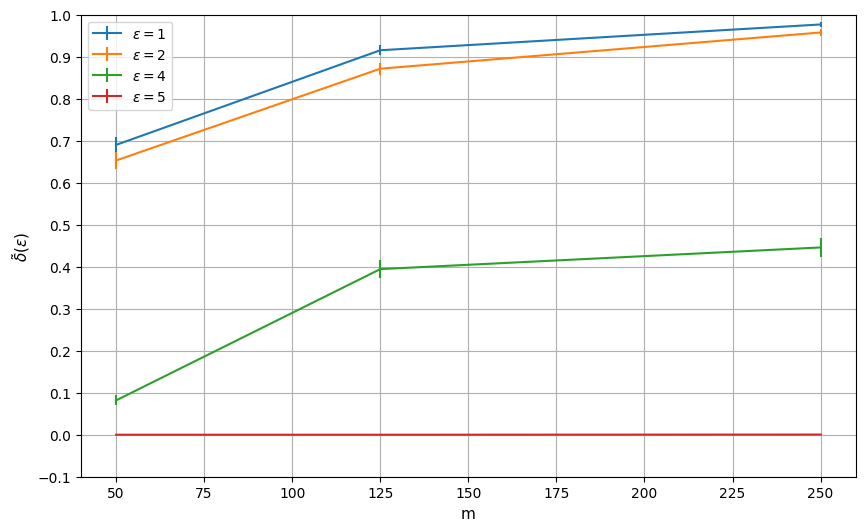

In [ ]:
# n = 500
# theta = 3
# sigma = 1/2
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei valori di m
m = np.array([50, 125, 250])

# Definizione dei valori di epsilon
epsilon_values = np.array([1, 2, 4, 5])

# Creazione di un array vuoto per memorizzare i valori di delta
delta = np.array([[0.69, 0.9154, 0.9768], [0.6529, 0.871499, 0.9577], [0.0817, 0.3943, 0.4459], [0, 0, 0.000399]])

# error
error = np.array([[0.02, 0.01229, 0.0066], [0.02102, 0.0147, 0.0088910], [0.01209, 0.02195, 0.02158], [0, 0, 0.00088]])

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Tracciamento delle linee per ogni valore di epsilon
for i, epsilon in enumerate(epsilon_values):
    plt.errorbar(m, delta[i], yerr=error[i], label=r'$\epsilon = {}$'.format(epsilon))

# Aggiunta di etichette agli assi
plt.xlabel('m', fontsize=11)
plt.ylabel(r'$\tilde{\delta}(\epsilon)$', fontsize=11)

plt.ylim(-0.1, 1)
plt.yticks(np.arange(-0.1, 1.01, 0.1))

# Aggiunta di una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

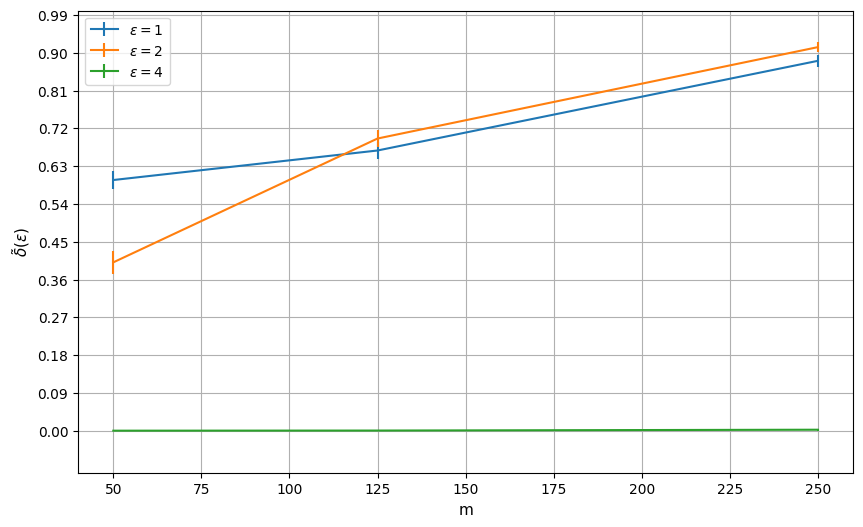

In [ ]:
# n = 500
# theta = 3
# sigma = 1/5
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei valori di m
m = np.array([50, 125, 250])

# Definizione dei valori di epsilon
epsilon_values = np.array([1, 2, 4])

# Creazione di un array vuoto per memorizzare i valori di delta
delta = np.array([[0.5969, 0.6672, 0.8807], [0.4009, 0.6957, 0.9133], [9.99e-5, 0.0003999, 0.0023999]])

# error
error = np.array([[0.021668, 0.0208, 0.01418], [0.0276, 0.02032, 0.012430], [0.00004417, 0.0008833, 0.00216147]])

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Tracciamento delle linee per ogni valore di epsilon
for i, epsilon in enumerate(epsilon_values):
    plt.errorbar(m, delta[i], yerr=error[i], label=r'$\epsilon = {}$'.format(epsilon))

# Aggiunta di etichette agli assi
plt.xlabel('m', fontsize=11)
plt.ylabel(r'$\tilde{\delta}(\epsilon)$', fontsize=11)

plt.ylim(-0.1, 1)
plt.yticks(np.arange(-9.99e-10, 1.01, 0.09))

# Aggiunta di una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

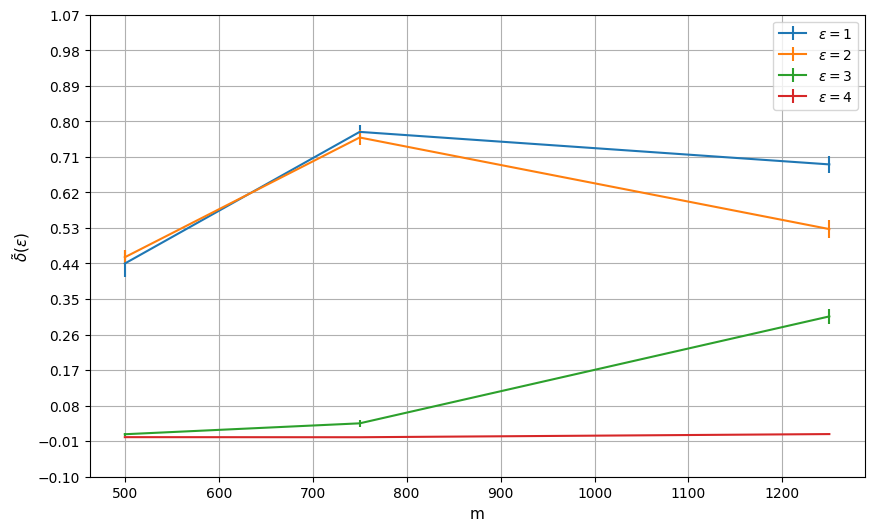

In [ ]:
# n = 5000
# theta = 3
# sigma = 1/5
import matplotlib.pyplot as plt
import numpy as np

# Definizione dei valori di m
m = np.array([500, 750, 1250])

# Definizione dei valori di epsilon
epsilon_values = np.array([1, 2, 3, 4])

# Creazione di un array vuoto per memorizzare i valori di delta
delta = np.array([[0.4399, 0.7733, 0.69093], [0.4558, 0.7591, 0.5271], [0.00760, 0.0352, 0.306], [0.0001999, 0, 0.008000]])

# error
error = np.array([[0.0340, 0.0184, 0.0215527], [0.0175, 0.0188, 0.022], [0.003836, 0.0081, 0.020], [0.000624, 0, 0]])

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Tracciamento delle linee per ogni valore di epsilon
for i, epsilon in enumerate(epsilon_values):
    plt.errorbar(m, delta[i], yerr=error[i], label=r'$\epsilon = {}$'.format(epsilon))

# Aggiunta di etichette agli assi
plt.xlabel('m', fontsize=11)
plt.ylabel(r'$\tilde{\delta}(\epsilon)$', fontsize=11)

plt.ylim(-0.1, 1)
plt.yticks(np.arange(-0.1, 1.1, 0.09))

# Aggiunta di una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()